In [2]:
# Importar las bibliotecas
import pandas as pd
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')
# Ruta donde se guardará el archivo en Google Drive
ruta_archivo = '/content/drive/My Drive/Tesis/data analisis.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
#Librerias
!pip install --upgrade numpy==1.26.4 scikit-learn==1.4.2
!pip install catboost lightgbm

import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr


## **PREPROCESAMIENTO DE LA DATA**

In [3]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Definir equipos según su ubicación geográfica
EQUIPOS_SIN_ALTURA = [
    '9 de Octubre FC', 'Barcelona SC', 'CS Emelec', 'Delfin SC',
    'Fuerza Amarilla SC', 'Guayaquil City FC', 'LDU Portoviejo',
    'Manta FC', 'Orense SC'
]

EQUIPOS_CON_ALTURA = [
    'CD Independiente del Valle', 'LDU de Quito', 'CD El Nacional',
    'Libertad FC', 'Imbabura SC', 'CD Macara', 'SD Aucas',
    'Mushuc Runa SC', 'CD Universidad Catolica', 'Cumbaya FC',
    'CD Tecnico Universitario', 'CD Cuenca', 'Gualaceo SC',
    'CD Olmedo', 'CD America Quito'
]

# Leer y preparar los datos
df = pd.read_excel(ruta_archivo)

# Calculo de Columna Saldo de Goles
df['Saldo_Goles'] = df['GF'] - df['GC']

# Codificar la formación del equipo visitante
encoder = OneHotEncoder(sparse_output=False)
formaciones_encoded = encoder.fit_transform(df[['Formación Visitante']])
formaciones_df = pd.DataFrame(
    formaciones_encoded,
    columns=[f"{categoria}" for categoria in encoder.categories_[0]]
)

# Codificar resultados del partido
resultados_df = pd.get_dummies(df['Resultado'], prefix='Resultado')

# Combinar los datos codificados con el dataframe original
df = pd.concat([df, formaciones_df, resultados_df], axis=1)

# Función para clasificar partidos según ubicación de equipos
def clasificar_partido(row):
    local = row['Local']
    visitante = row['Visitante']

    if local in EQUIPOS_CON_ALTURA and visitante in EQUIPOS_CON_ALTURA:
        return 'Altura vs Altura'
    elif local in EQUIPOS_SIN_ALTURA and visitante in EQUIPOS_SIN_ALTURA:
        return 'Costa vs Costa'
    elif local in EQUIPOS_CON_ALTURA and visitante in EQUIPOS_SIN_ALTURA:
        return 'Altura vs Costa'
    elif local in EQUIPOS_SIN_ALTURA and visitante in EQUIPOS_CON_ALTURA:
        return 'Costa vs Altura'
    else:
        return 'Desconocido'

# Aplicar la clasificación al dataframe
df['clasificacion_del_partido'] = df.apply(clasificar_partido, axis=1)

# Separar el dataframe según la clasificación del partido
df_sierra_costa = df[df['clasificacion_del_partido'] == 'Altura vs Costa']
df_costa_sierra = df[df['clasificacion_del_partido'] == 'Costa vs Altura']
df_sierra_sierra = df[df['clasificacion_del_partido'] == 'Altura vs Altura']
df_costa_costa = df[df['clasificacion_del_partido'] == 'Costa vs Costa']


## **IMPLEMENTACION DE MODELOS**

Entrenando Regresión Lineal...
Entrenando Ridge Regression...
Entrenando Random Forest...
Entrenando SVM...
Entrenando MLP...
Entrenando XGBoost...
Entrenando LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 1219, number of used features: 14
[LightGBM] [Info] Start training from score -0.447088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

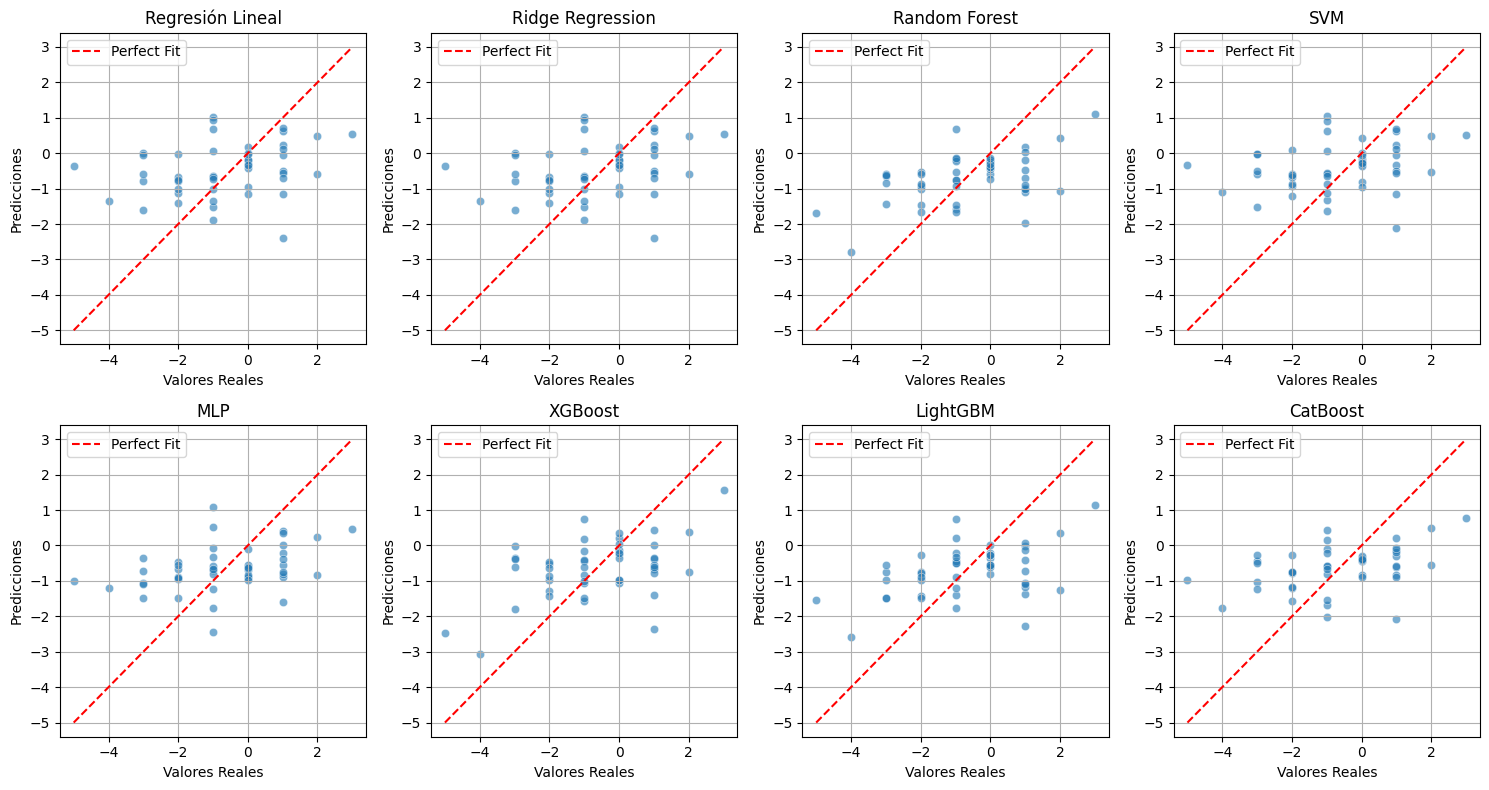

In [4]:

# Función para calcular métricas
def evaluar_modelo(y_true, y_pred):
    return {
        "R-squared": r2_score(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "SMAPE": np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-10)) * 100,
        "Pearson Corr": pearsonr(y_true, y_pred)[0]
    }

# Variables predictoras
x_variables = [
    'P. Victoria', 'P. Empate', 'P. Perdida', 'Altura', 'diferencia_altitud',
    '3-1-4-2', '3-4-1-2', '3-4-3', '3-5-2', '4-1-4-1', '4-2-3-1',
    '4-3-1-2', '4-3-2-1', '4-3-3', '4-4-1-1', '4-4-2', '4-5-1',
    '5-3-2', '5-4-1'
]

y_variable = "Saldo_Goles"

# División de los datos
train_data = df[df['Fecha'].dt.year != 2024]
test_data = df[(df['Fecha'].dt.year == 2024) & (df['clasificacion_del_partido'] == 'Altura vs Costa')]

X_train, y_train = train_data[x_variables], train_data[y_variable]
X_test, y_test = test_data[x_variables], test_data[y_variable]

# Normalizar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir modelos
modelos = {
    "Regresión Lineal": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    "SVM": SVR(kernel='linear', C=1.0, epsilon=0.1),
    "MLP": MLPRegressor(hidden_layer_sizes=100, activation='relu', solver='adam', max_iter=300, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42),
    "CatBoost": CatBoostRegressor(n_estimators=200, learning_rate=0.05, depth=5, verbose=0, random_seed=42)
}

resultados, predicciones = {}, {}

# Entrenar y evaluar modelos
for nombre, modelo in modelos.items():
    print(f"Entrenando {nombre}...")
    modelo.fit(X_train_scaled, y_train)
    y_pred = modelo.predict(X_test_scaled)
    predicciones[nombre] = y_pred
    resultados[nombre] = evaluar_modelo(y_test, y_pred)

# Resultados
print("\nResultados Comparativos:")
for nombre, metricas in resultados.items():
    print(f"\n{nombre}:")
    for metrica, valor in metricas.items():
        print(f"  {metrica}: {valor:.4f}")

# Gráficos
plt.figure(figsize=(15, 8))
for i, (nombre, y_pred) in enumerate(predicciones.items()):
    plt.subplot(2, 4, i + 1)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
    plt.xlabel("Valores Reales")
    plt.ylabel("Predicciones")
    plt.title(nombre)
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()
